### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'DR_ICDR'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


image_id  patient_id    camera  patient_age comorbidities diabetes_time_y  \
0  img00001           1  Canon CR         48.0     diabetes1              12   
1  img00002           1  Canon CR         48.0     diabetes1              12   
2  img00003           2  Canon CR         18.0     diabetes1               7   
3  img00004           2  Canon CR         18.0     diabetes1               7   
4  img00005           3  Canon CR         22.0     diabetes1              11   

  insuline  patient_sex  exam_eye diabetes  ... vascular_occlusion  \
0      yes            1         1      yes  ...                  0   
1      yes            1         2      yes  ...                  0   
2      yes            2         1      yes  ...                  0   
3      yes            2         2      yes  ...                  0   
4      yes            1         1      yes  ...                  0   

  hypertensive_retinopathy  drusens  hemorrhage  retinal_detachment  \
0                        0        0           0                   0   
1                        0        0           0                   0   
2                        0        0           0                   0   
3                        0        0           0                   0   
4                        0        0           0                   0   

   myopic_fundus  increased_cup_disc  other   quality  normality  
0              0                   1      0  Adequate   abnormal  
1              0                   1      0  Adequate   abnormal  
2              0                   0      0  Adequate     normal  
3              0                   0      0  Adequate     normal  
4              0                   0      0  Adequate     normal  

[5 rows x 35 columns]

In [4]:
# Convert into 3 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else 'Diabetic Retinopathy')

Train data shape: (11386, 35)
Test data shape: (4880, 35)


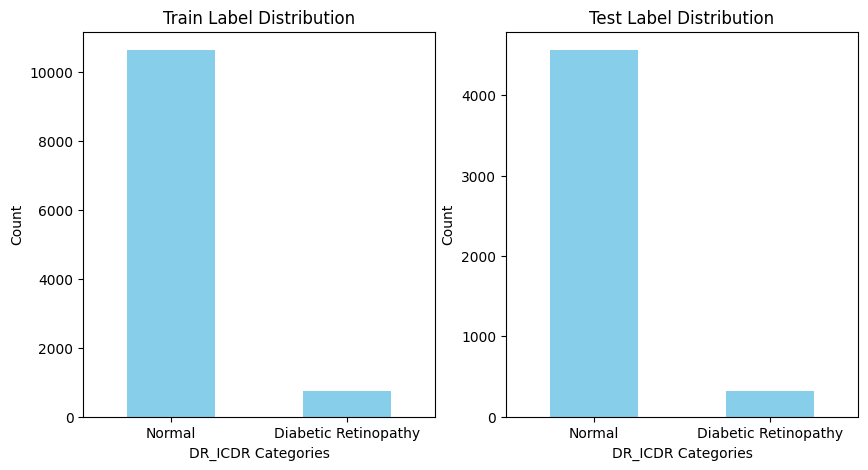

Getting validation set...
Train data shape: (3904, 35)
Test data shape: (976, 35)


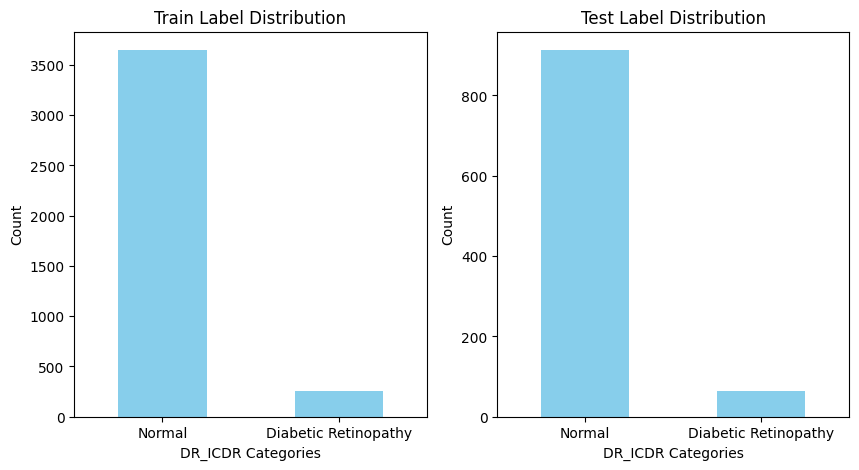

In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

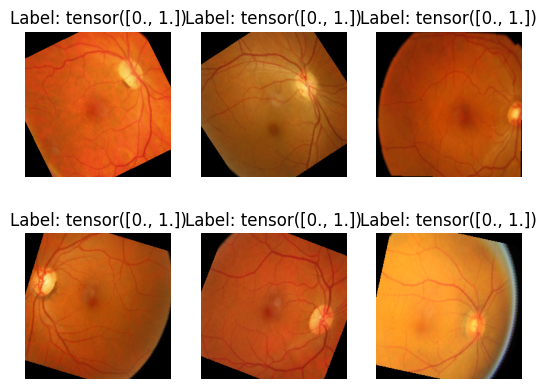

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone='convnextv2_binary_DR')

100%|██████████| 61/61 [00:18<00:00,  3.38it/s]


Epoch 1, Train Loss: 0.5474252680609568, Val Loss: 0.452745364337671, F1 Score: 0.6346765888310906


100%|██████████| 61/61 [00:18<00:00,  3.37it/s]


Epoch 2, Train Loss: 0.4656111916129509, Val Loss: 0.3693240751497081, F1 Score: 0.7723046158973504


100%|██████████| 61/61 [00:18<00:00,  3.37it/s]


Epoch 3, Train Loss: 0.44138499152626887, Val Loss: 0.39059665225079804, F1 Score: 0.6784759810370292


100%|██████████| 61/61 [00:17<00:00,  3.41it/s]


Epoch 4, Train Loss: 0.42146738235618963, Val Loss: 0.31760495375902925, F1 Score: 0.7939885173927728


100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


Epoch 5, Train Loss: 0.39658222676076915, Val Loss: 0.30209411216563864, F1 Score: 0.806554958783755


100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


Epoch 6, Train Loss: 0.38214322419711544, Val Loss: 0.28869548476621754, F1 Score: 0.8875368731563422


100%|██████████| 61/61 [00:18<00:00,  3.35it/s]


Epoch 7, Train Loss: 0.3671895475702339, Val Loss: 0.3085082928176786, F1 Score: 0.834810687392766


100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


Epoch 8, Train Loss: 0.35189290663876227, Val Loss: 0.32651353297663516, F1 Score: 0.8829495614035088


100%|██████████| 61/61 [00:18<00:00,  3.38it/s]


Epoch 9, Train Loss: 0.33863998677455975, Val Loss: 0.26558674725352743, F1 Score: 0.8644444444444445


100%|██████████| 61/61 [00:18<00:00,  3.35it/s]


Epoch 10, Train Loss: 0.31270948902630574, Val Loss: 0.27490678594493473, F1 Score: 0.8829495614035088


100%|██████████| 61/61 [00:18<00:00,  3.28it/s]


Epoch 11, Train Loss: 0.3158449129845026, Val Loss: 0.24780723354855522, F1 Score: 0.8908329738107792


100%|██████████| 61/61 [00:18<00:00,  3.31it/s]


Epoch 12, Train Loss: 0.2907778134130025, Val Loss: 0.2569890814360048, F1 Score: 0.9011061386473022


100%|██████████| 61/61 [00:18<00:00,  3.36it/s]


Epoch 13, Train Loss: 0.2851622479763719, Val Loss: 0.2200182347146214, F1 Score: 0.8484963944512651


100%|██████████| 61/61 [00:18<00:00,  3.37it/s]


Epoch 14, Train Loss: 0.27045107947589225, Val Loss: 0.23794592324583258, F1 Score: 0.8019870155420028


100%|██████████| 61/61 [00:17<00:00,  3.39it/s]


Epoch 15, Train Loss: 0.2623839697047147, Val Loss: 0.24638192392274982, F1 Score: 0.8876856595253306


100%|██████████| 61/61 [00:18<00:00,  3.37it/s]


Epoch 16, Train Loss: 0.22844845249338516, Val Loss: 0.22132026373607214, F1 Score: 0.907488569223339


100%|██████████| 61/61 [00:18<00:00,  3.31it/s]


Epoch 17, Train Loss: 0.21886073262953942, Val Loss: 0.24913851092340517, F1 Score: 0.8783213689650319


100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


Epoch 18, Train Loss: 0.2951763759189275, Val Loss: 0.45151555770244756, F1 Score: 0.7449559201749439


100%|██████████| 61/61 [00:18<00:00,  3.36it/s]


Epoch 19, Train Loss: 0.3042078554797708, Val Loss: 0.2575602096612336, F1 Score: 0.8675161466885606


100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


Epoch 20, Train Loss: 0.2220788508695498, Val Loss: 0.15592596939474831, F1 Score: 0.8845789971617786


100%|██████████| 61/61 [00:18<00:00,  3.30it/s]


Epoch 21, Train Loss: 0.19210713193621068, Val Loss: 0.15966574582042264, F1 Score: 0.9072116795562297
Early stopping triggered.


### Test

100%|██████████| 244/244 [01:09<00:00,  3.52it/s]


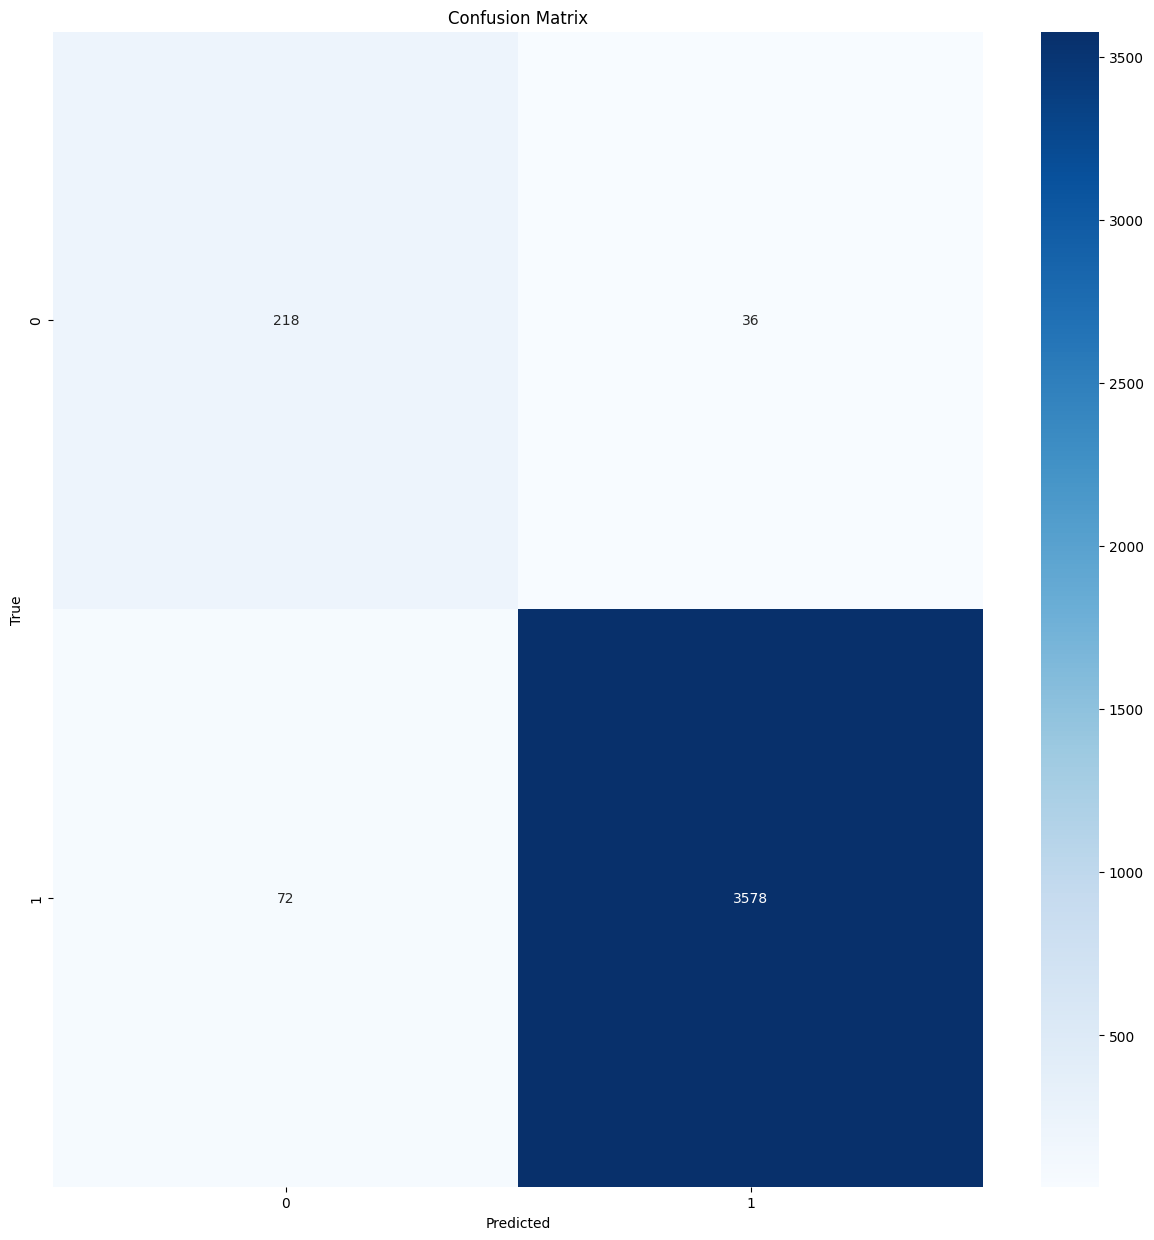

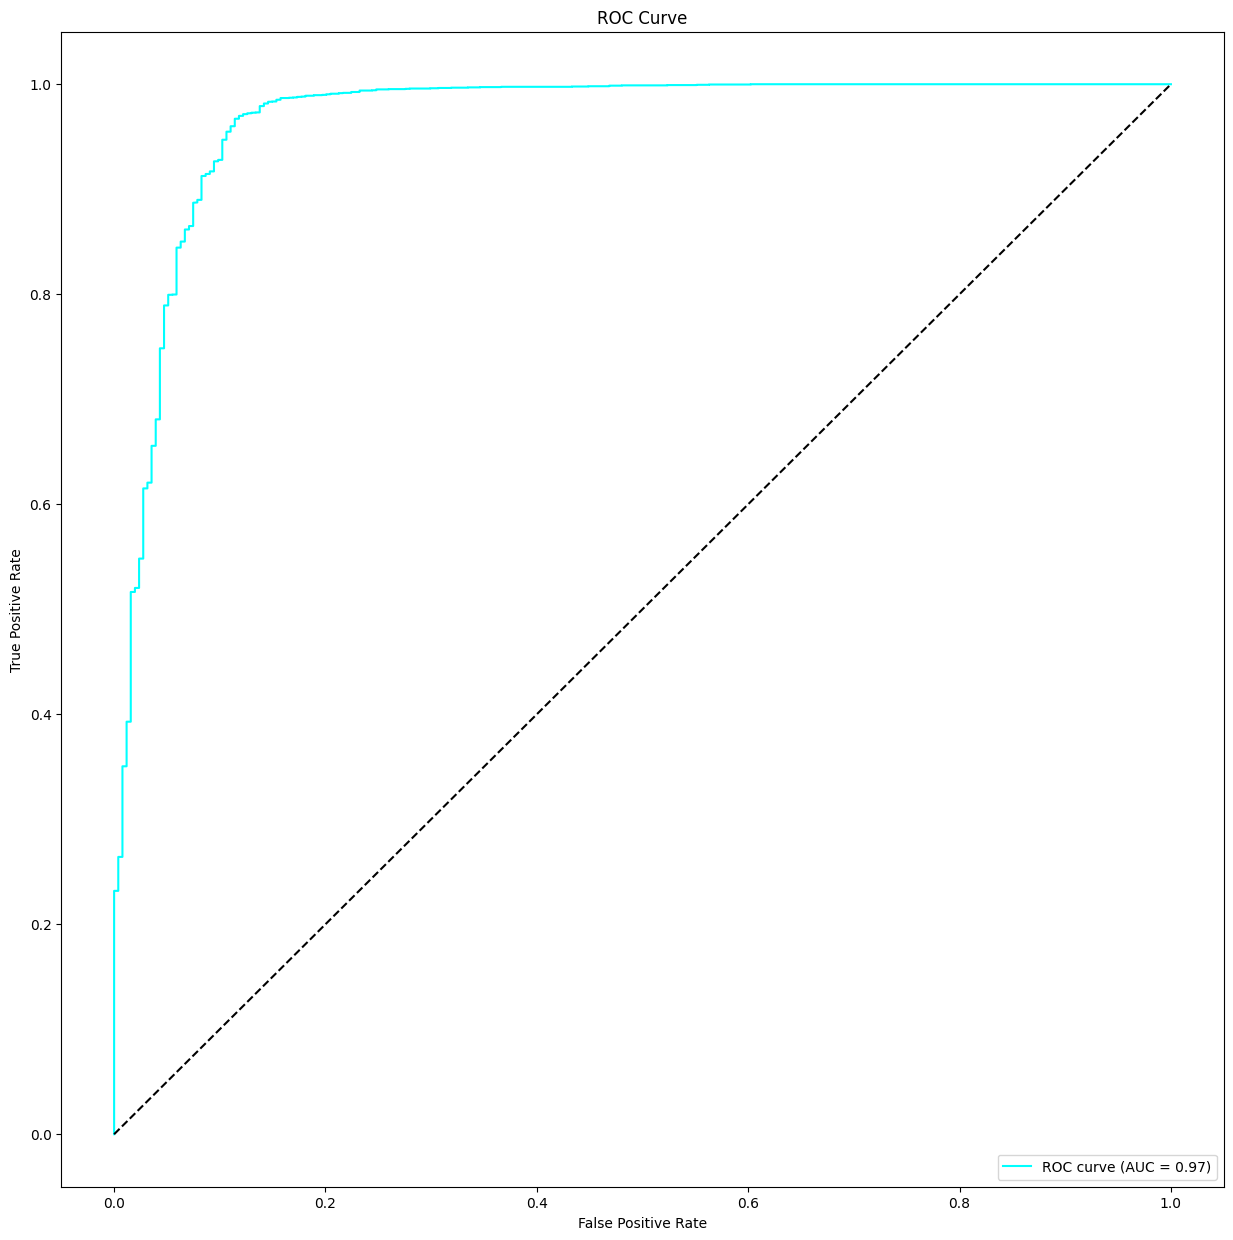

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       254
           1       0.99      0.98      0.99      3650

    accuracy                           0.97      3904
   macro avg       0.87      0.92      0.89      3904
weighted avg       0.97      0.97      0.97      3904

##################################################  Saliency Maps  ##################################################

Class 0:


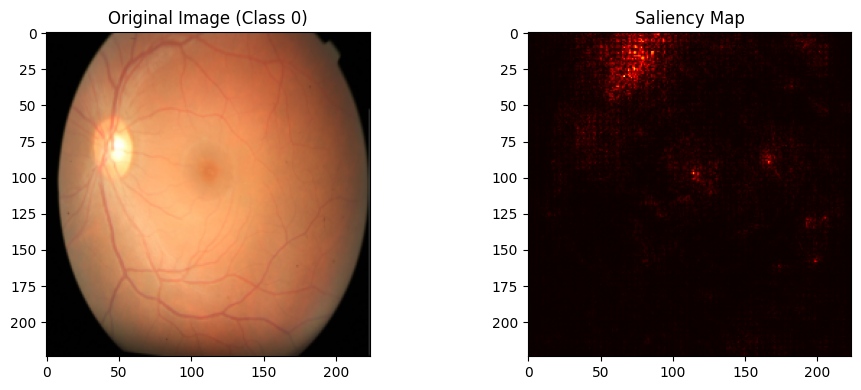

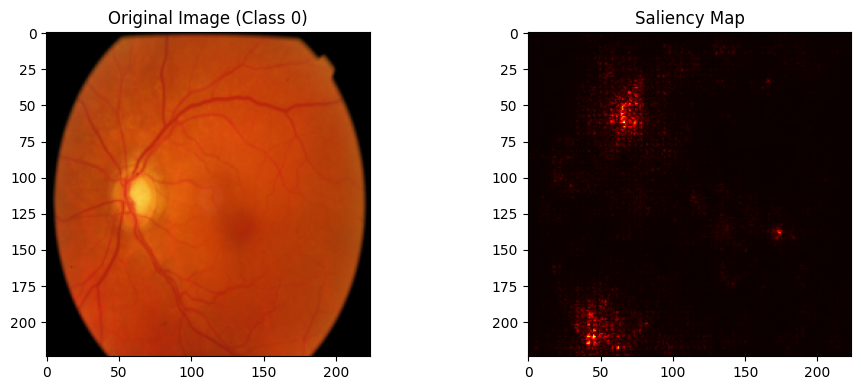

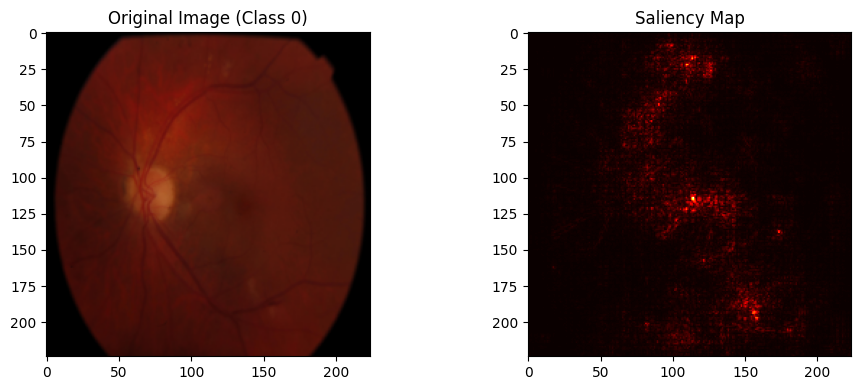

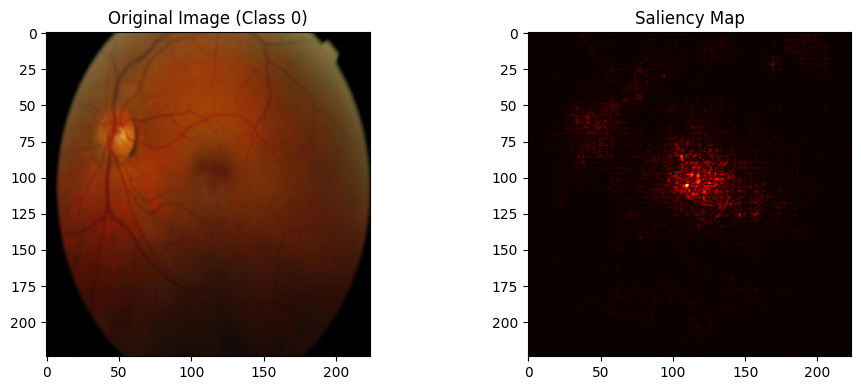

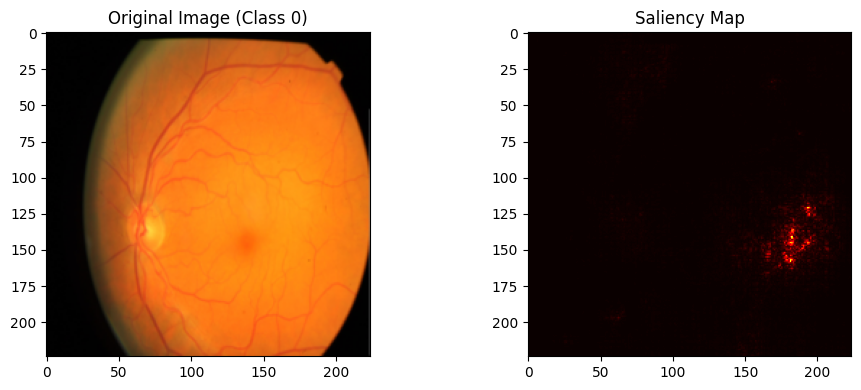

Class 1:


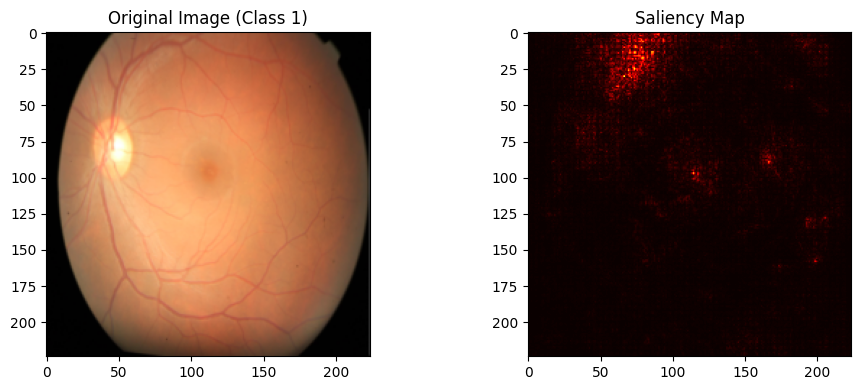

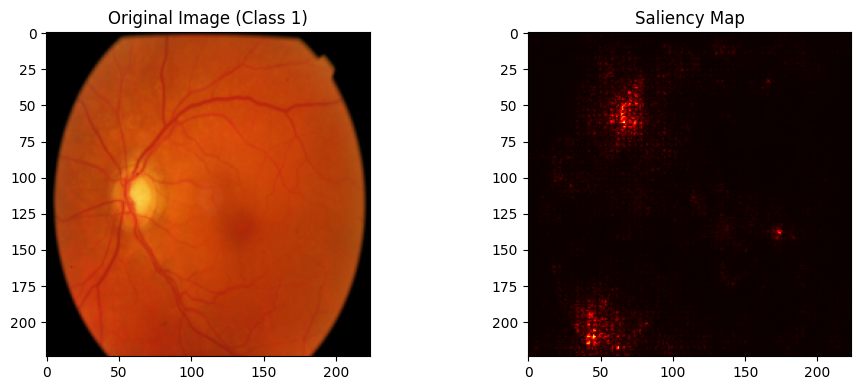

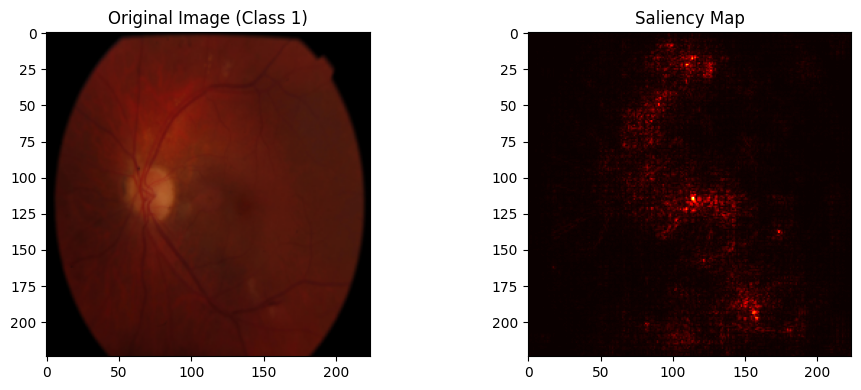

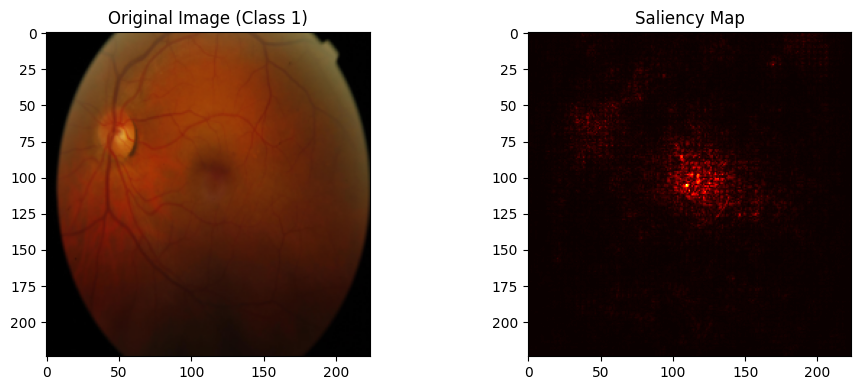

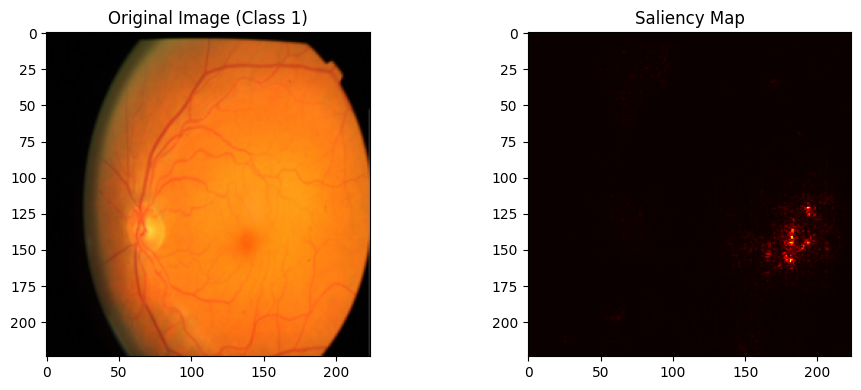

In [15]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [19]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

# Metrics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

# Generate Saliency Maps
def get_saliency_map(model, input_image):
    model.eval()
    input_image.requires_grad_()
    output = model(input_image)
    max_idx = output.argmax()
    output[0, max_idx].backward()
    saliency_map, _ = torch.max(input_image.grad.data.abs(),dim=1)
    #saliency_map = input_image.grad.data.abs().max(1)[0]
    return saliency_map

def test_model(y_test, y_pred, y_prob=None):
    """
    Evaluates the model on the training and test data respectively
    1. Predictions on test data
    2. Classification report
    3. Confusion matrix
    4. ROC curve

    Inputs:
    y_test: numpy array with test labels
    y_pred: numpy array with predicted test labels
    """
    
    plot_matrix = False
    if y_pred.shape[1] < 102:
        plot_matrix = True
        
    
    if y_pred.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
    
    # Confusion matrix
    # Create a confusion matrix of the test predictions
    if plot_matrix:
        cm = confusion_matrix(y_test, y_pred)
        # create heatmap
        # Set the size of the plot
        fig, ax = plt.subplots(figsize=(15, 15))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)
        # Set plot labels
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        # Display plot
        plt.show()

    #create ROC curve
    from sklearn.preprocessing import LabelBinarizer
    fig, ax = plt.subplots(figsize=(15, 15))

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_pred = label_binarizer.transform(y_pred)
    
    if (y_onehot_pred.shape[1] < 2):
        fpr, tpr, _ = roc_curve(y_test,  y_pred)

        #create ROC curve
        #plt.plot(fpr,tpr)
        if y_prob is not None:
            RocCurveDisplay.from_predictions(
                    y_test,
                    y_prob,
                    name=f"ROC curve",
                    color='aqua',
                    ax=ax,
                )
        else:
            RocCurveDisplay.from_predictions(
                    y_test,
                    y_pred,
                    name=f"ROC curve",
                    color='aqua',
                    ax=ax,
                )
        plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
        plt.title('ROC Curve')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    else:
        from itertools import cycle
        colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "yellow", "purple", "pink", "brown", "black"])
        if y_prob is None:
            for class_id, color in zip(range(len(label_binarizer.classes_)), colors):
                RocCurveDisplay.from_predictions(
                    y_onehot_test[:, class_id],
                    y_onehot_pred[:, class_id],
                    name=f"ROC curve for {label_binarizer.classes_[class_id]}",
                    color=color,
                    ax=ax,
                )
        else:
            for class_id, color in zip(range(len(label_binarizer.classes_)), colors):
                RocCurveDisplay.from_predictions(
                    y_onehot_test[:, class_id],
                    y_prob[:, class_id],
                    name=f"ROC curve for {label_binarizer.classes_[class_id]}",
                    color=color,
                    ax=ax,
                )

        plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
        plt.show()
        
    # Classification report
    # Create a classification report of the test predictions
    cr = classification_report(y_test, y_pred)
    # print classification report
    print(cr)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Use weighted average for multi-class precision
    recall = recall_score(y_test, y_pred, average='weighted')  # Use weighted average for multi-class recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average for multi-class F1-score

    return accuracy, precision, recall, f1


def test(model, test_dataloader, saliency=True, device='cpu', save=False):

    model.to(device)
    model.eval()

    output_size = test_dataloader.dataset.labels.shape[1]
    num_classes = 2 if test_dataloader.dataset.labels.shape[1] == 1 else test_dataloader.dataset.labels.shape[1]

    eval_images_per_class = {i: [] for i in range(num_classes)}
    
    with torch.no_grad():
        y_true, y_pred = [], []
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            image, labels =  batch['image'].to(device), batch['labels'].to(device)

            outputs = model(image)

            if (output_size == 1):
                preds = torch.sigmoid(outputs)
            else:
                preds = torch.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            # Get 5 images per class for saliency maps
            for i in range(num_classes):
                if len(eval_images_per_class[i]) < 5:
                    if (output_size == 1):
                        eval_images_per_class[i] += [img for i, img in enumerate(image) if labels[i] == i]
                    else:
                        eval_images_per_class[i] += [img for i, img in enumerate(image) if np.argmax(labels[i].cpu().numpy()) == i]
                    
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        
        if (output_size == 1):
            y_pred_one_hot = (y_pred > 0.5).astype(int)
        else:
            predicted_class_indices = np.argmax(y_pred, axis=1)
            # Convert the predicted class indices to one-hot encoding
            y_pred_one_hot = np.eye(y_pred.shape[1])[predicted_class_indices]
            
        # If the output size is 2, then we just need the probabilities of the positive class
        if (output_size == 2):
            y_pred = y_pred[:, 1]
        
        test_model(y_true, y_pred_one_hot, y_pred)
    
    if saliency:
        if save:
            os.makedirs('saliency_maps', exist_ok=True)
        
        print('#' * 50, f' Saliency Maps ', '#' * 50)
        print('')

        # Select some evaluation images to generate saliency maps
        eval_images = []
        for img_class in eval_images_per_class.keys():
            eval_images = eval_images_per_class[img_class][:5]

            print(f'Class {img_class}:')
            i = 0
            for eval_image in eval_images:
                eval_image = eval_image.unsqueeze(0)  # Add batch dimension
                saliency_map = get_saliency_map(model, eval_image)

                # Plot original image and saliency map side by side
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(eval_image[0].permute(1, 2, 0).detach().cpu().numpy())
                plt.title(f'Original Image (Class {img_class})')
                
                plt.subplot(1, 2, 2)
                plt.imshow(saliency_map[0].detach().cpu().numpy(), cmap=plt.cm.hot)
                plt.title('Saliency Map')
                
                plt.tight_layout()
                if save:
                    plt.savefig(f'saliency_maps/saliency_map_class_{img_class}_image_{i}.pdf')
                    i+=1
                    
                plt.show()



100%|██████████| 216/216 [01:00<00:00,  3.55it/s]


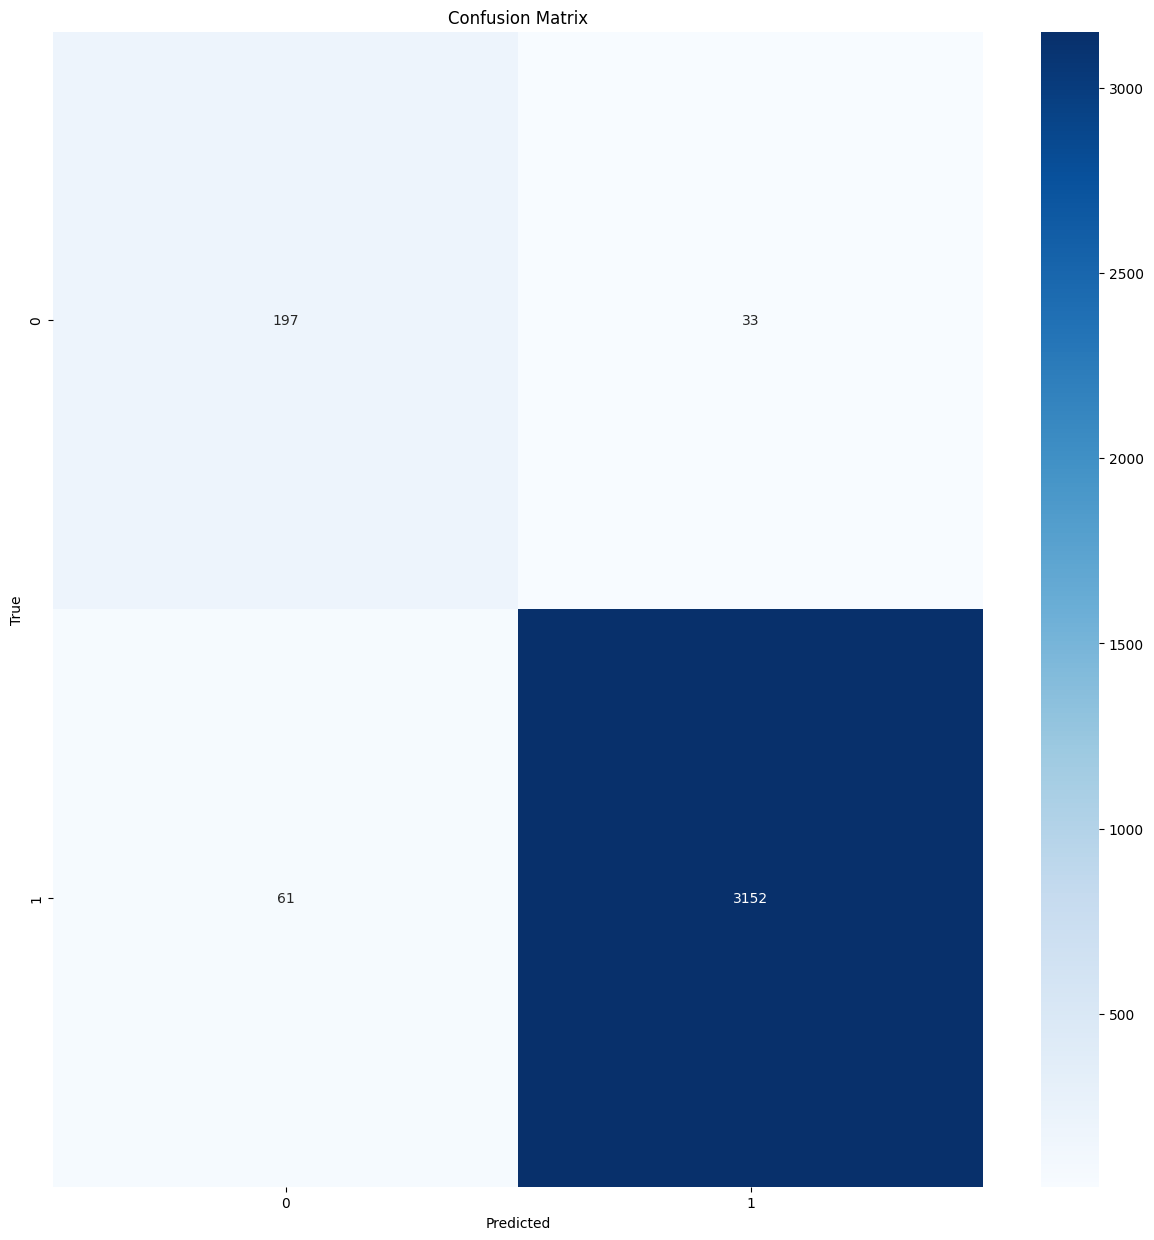

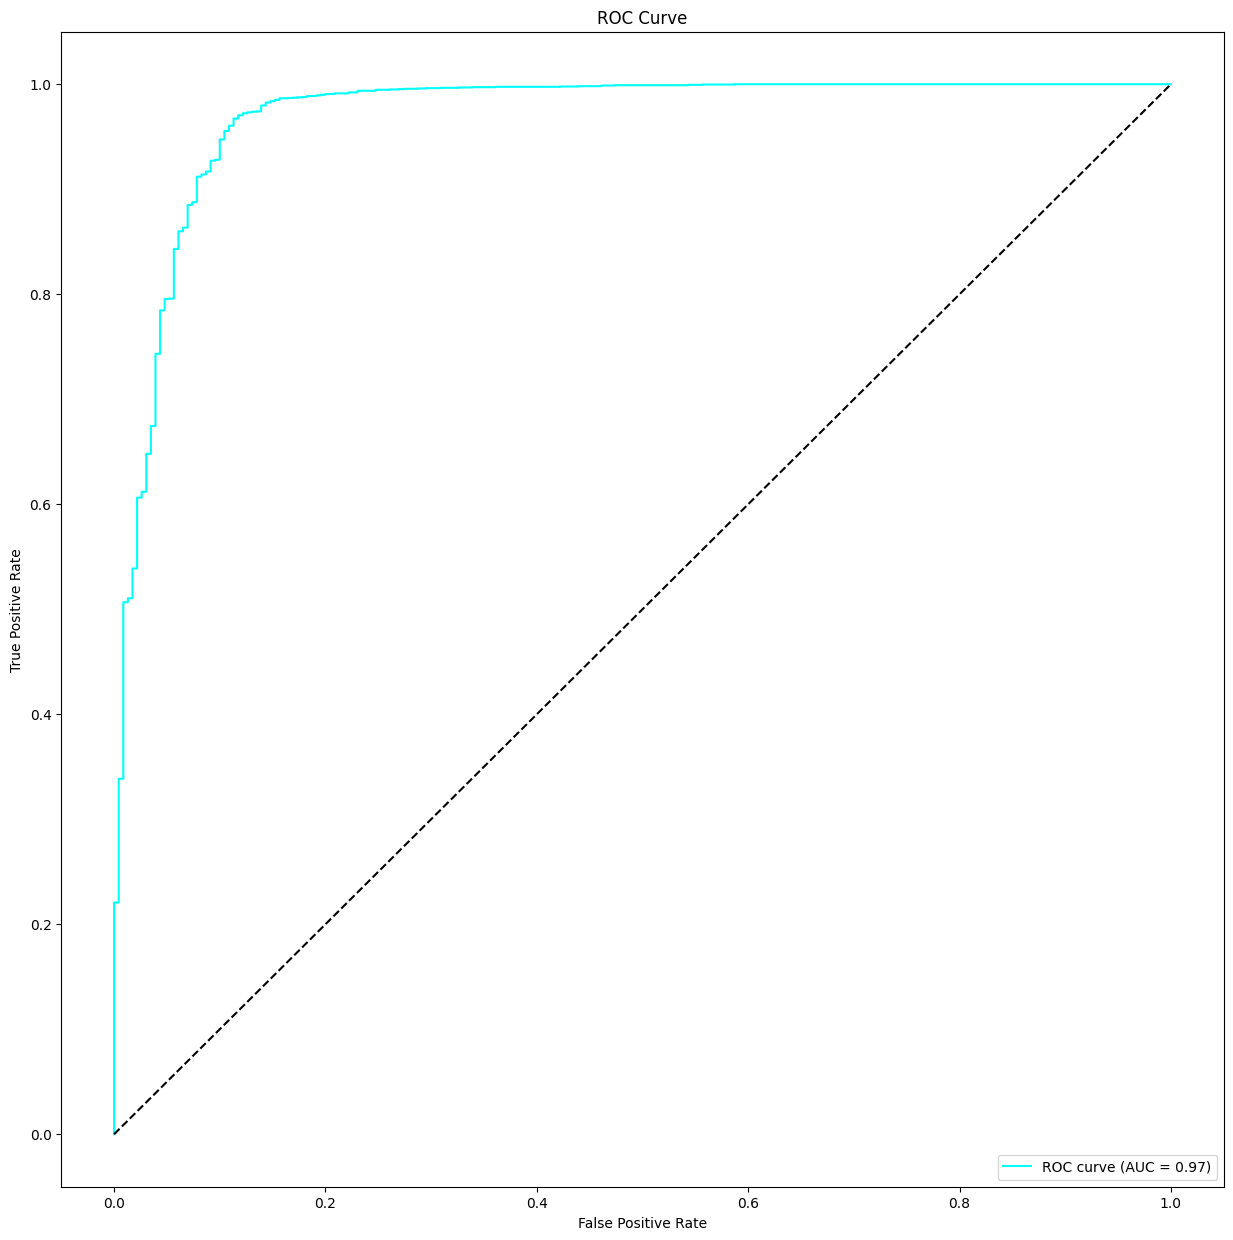

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       230
           1       0.99      0.98      0.99      3213

    accuracy                           0.97      3443
   macro avg       0.88      0.92      0.90      3443
weighted avg       0.97      0.97      0.97      3443

##################################################  Saliency Maps  ##################################################

Class 0:


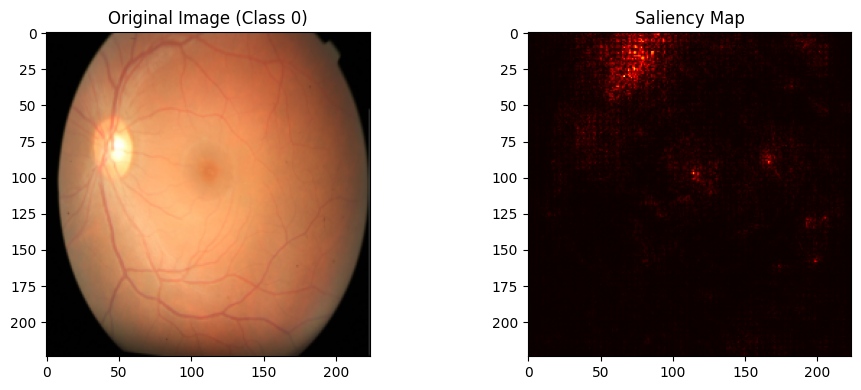

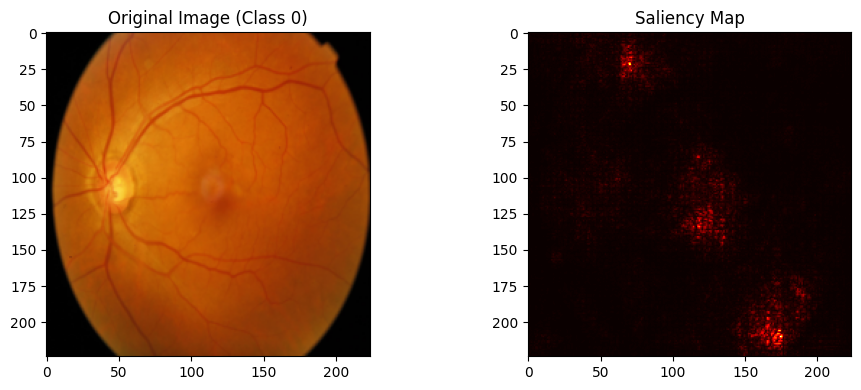

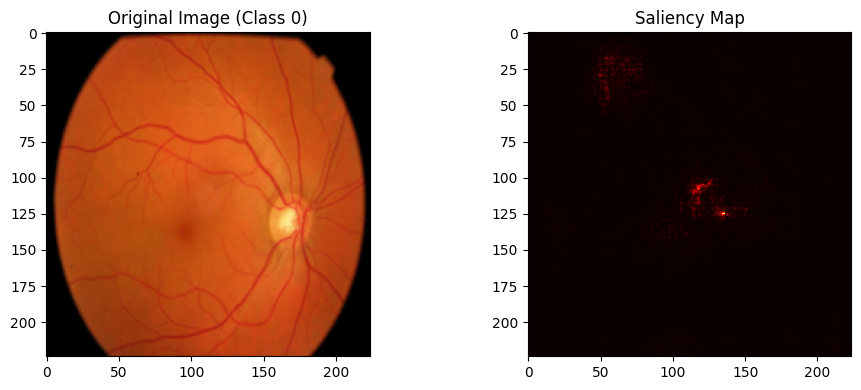

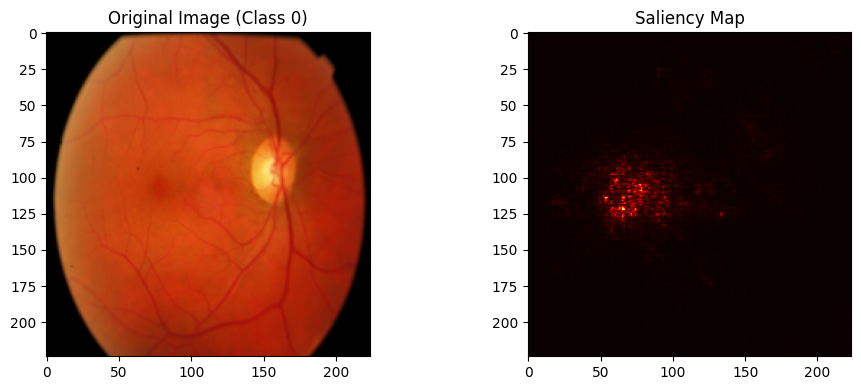

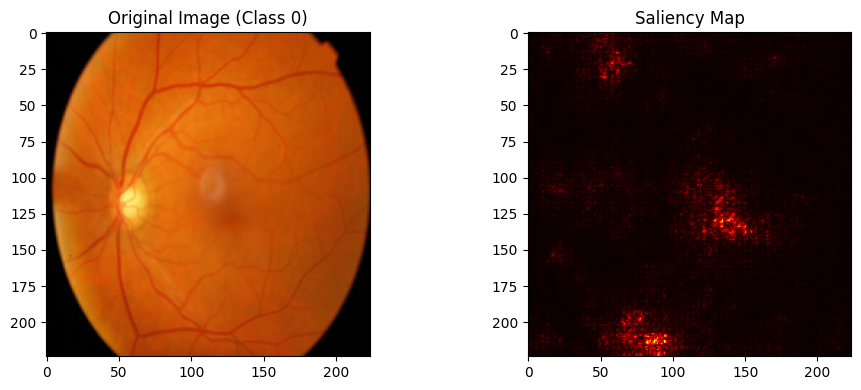

Class 1:


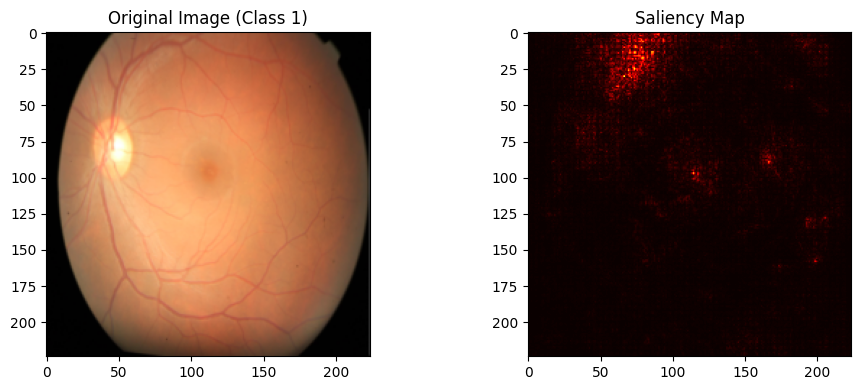

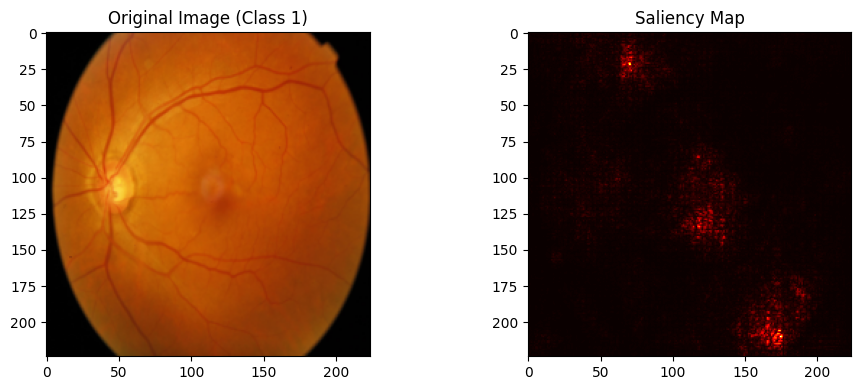

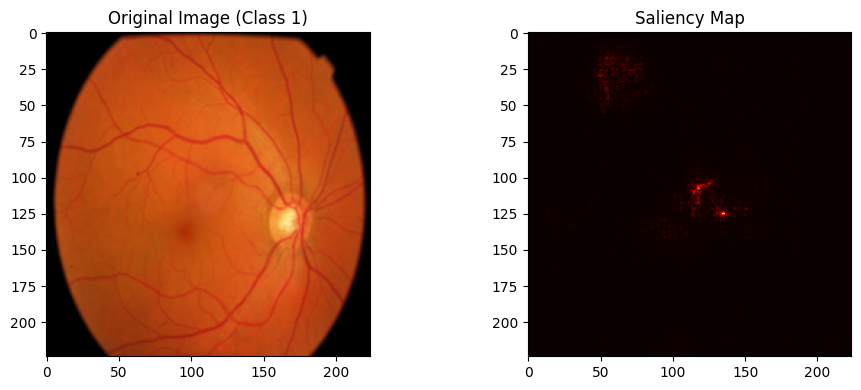

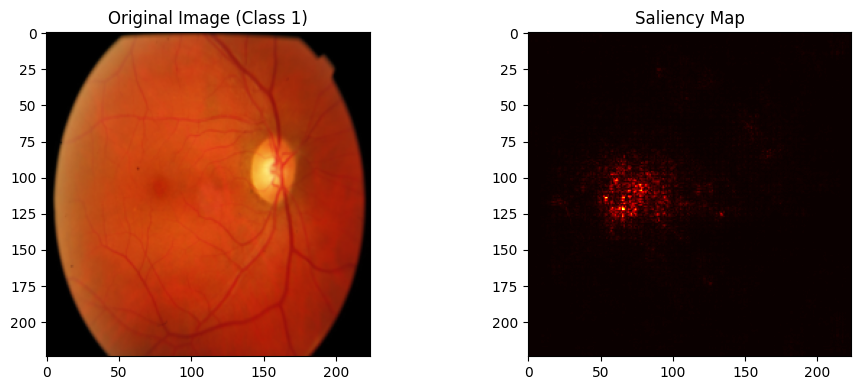

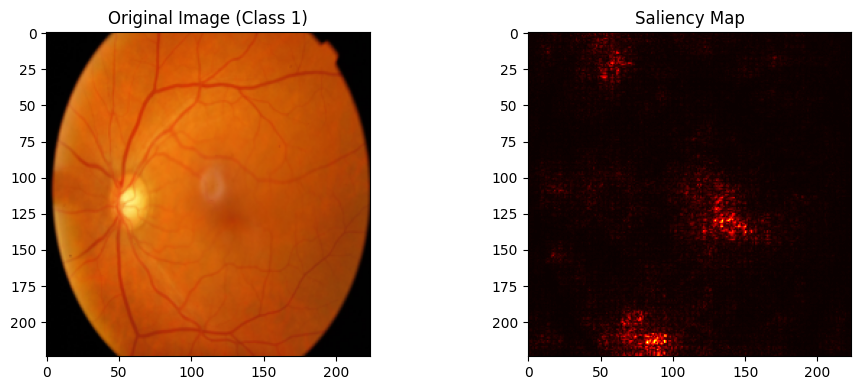

In [23]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

 21%|██        | 6/29 [00:02<00:08,  2.61it/s]

100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


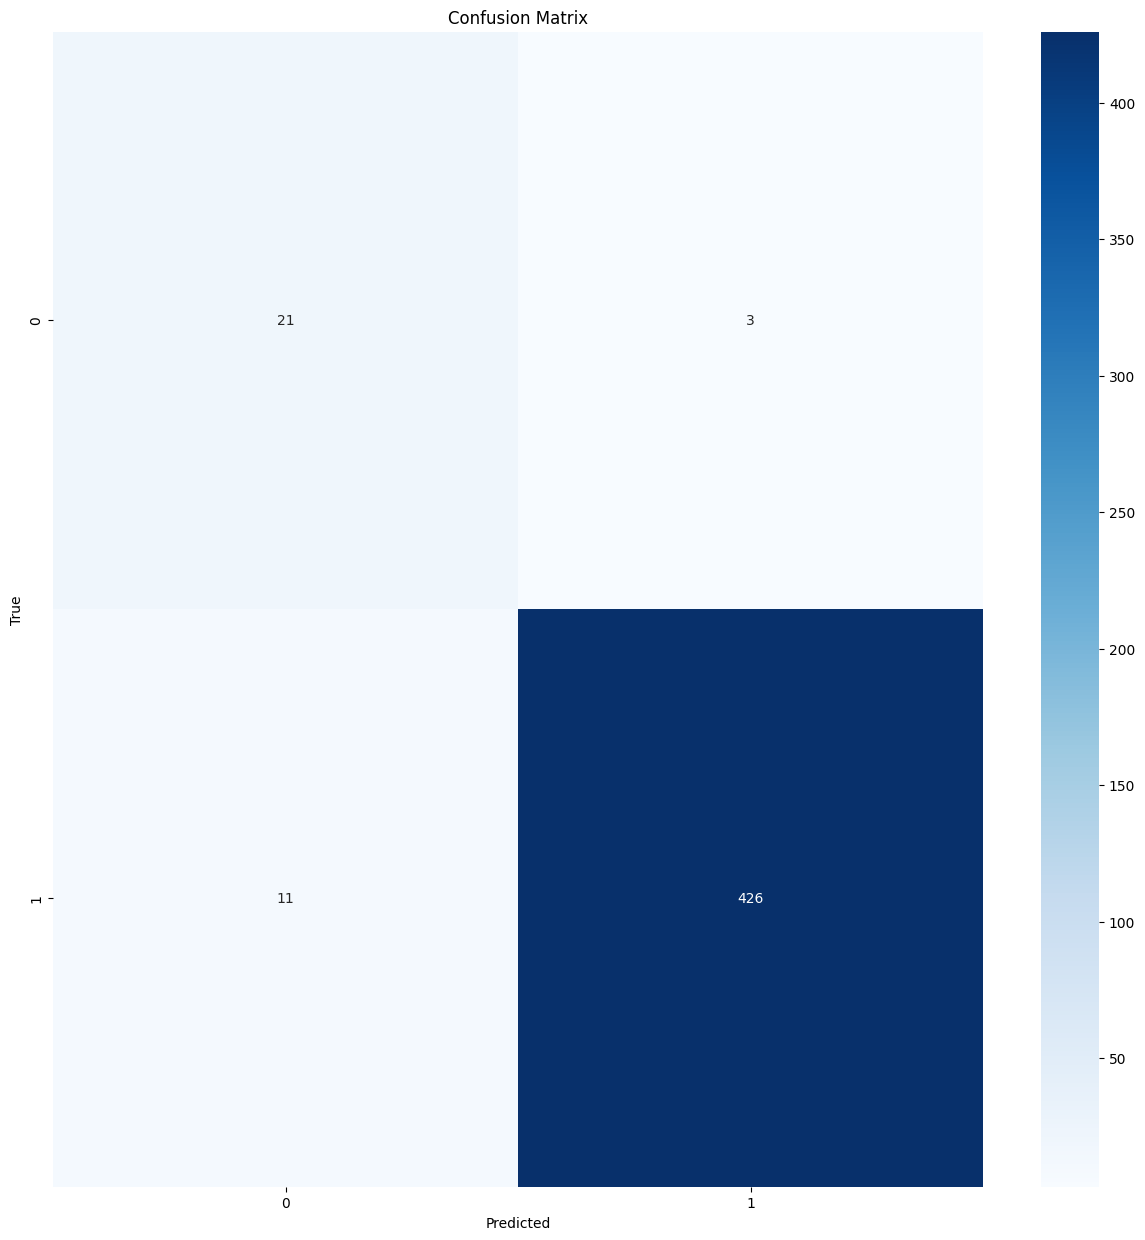

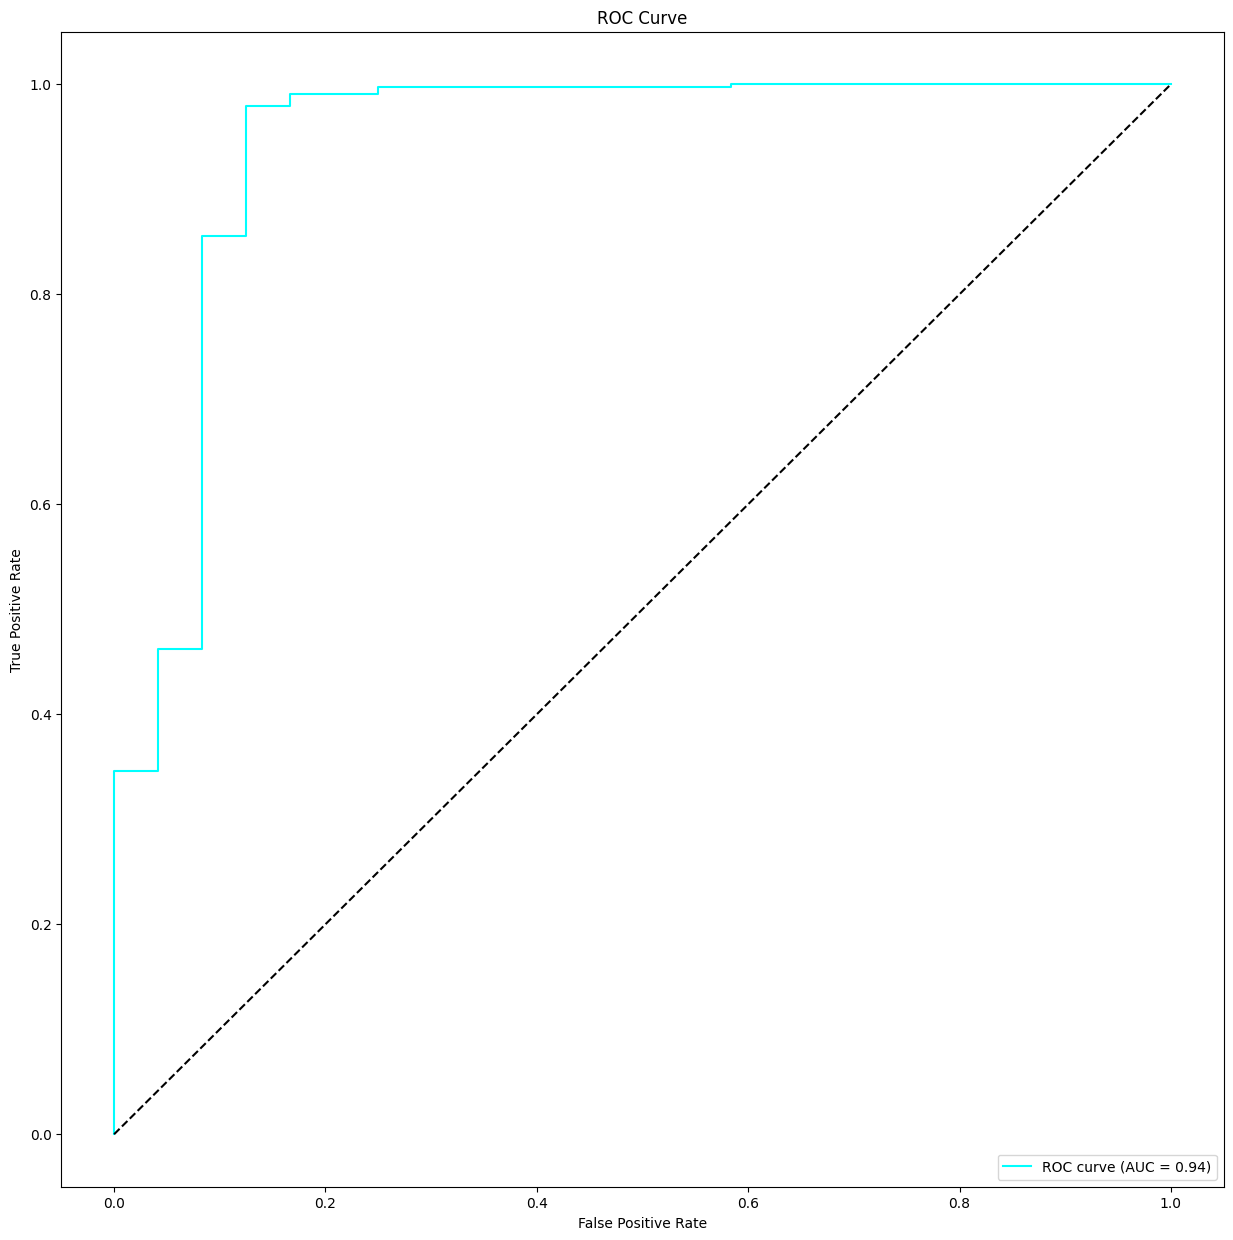

              precision    recall  f1-score   support

           0       0.66      0.88      0.75        24
           1       0.99      0.97      0.98       437

    accuracy                           0.97       461
   macro avg       0.82      0.92      0.87       461
weighted avg       0.98      0.97      0.97       461

##################################################  Saliency Maps  ##################################################

Class 0:


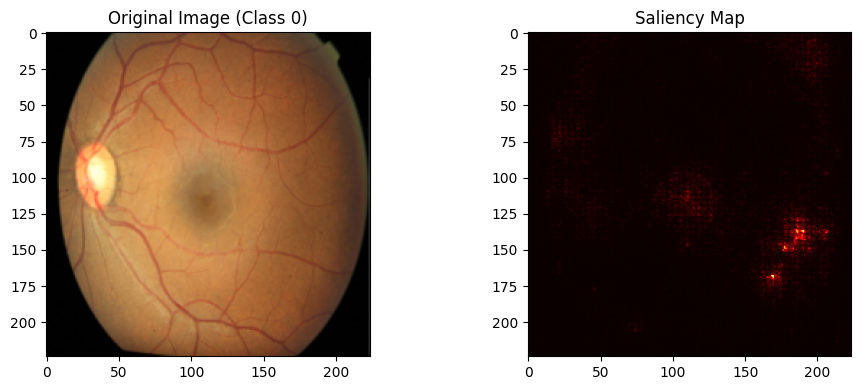

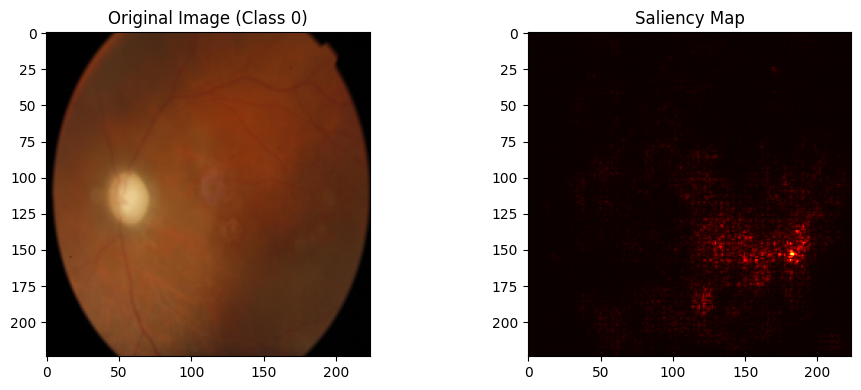

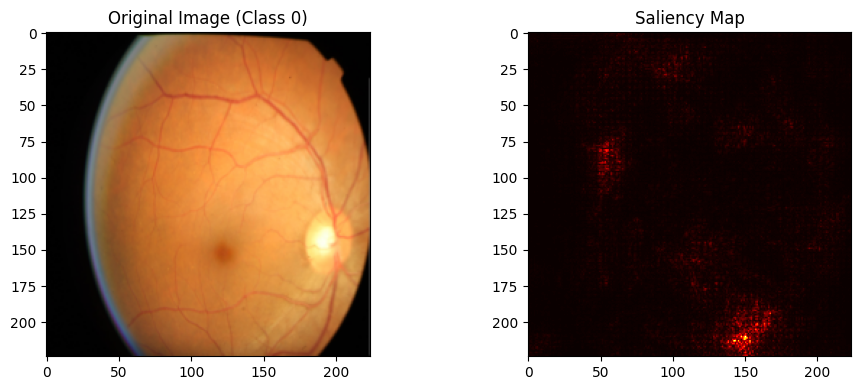

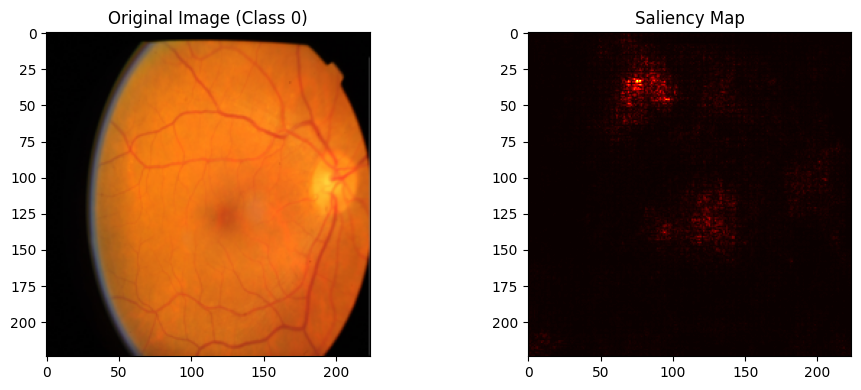

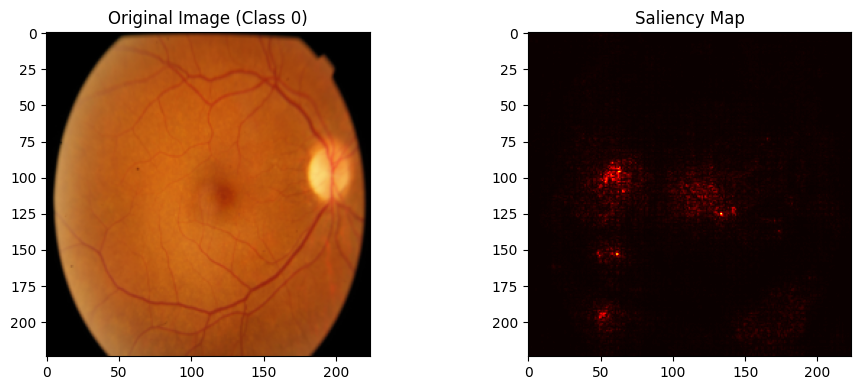

Class 1:


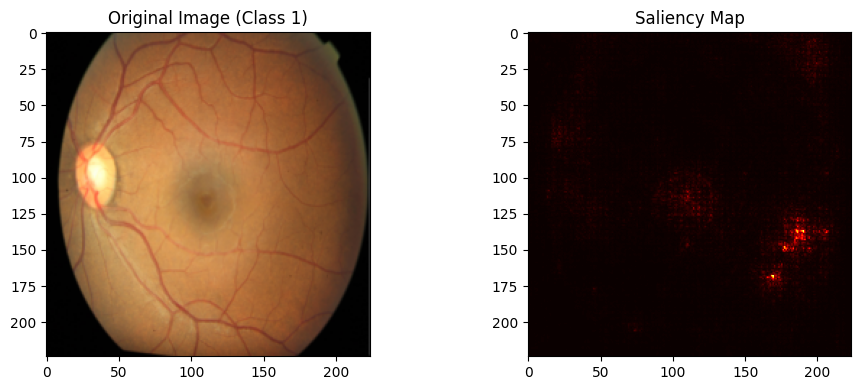

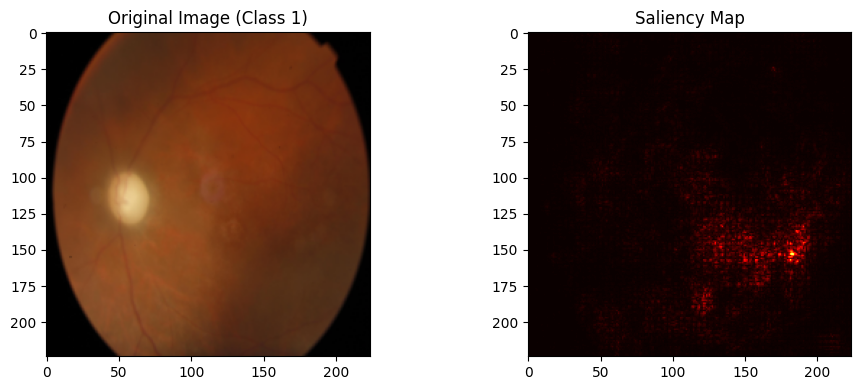

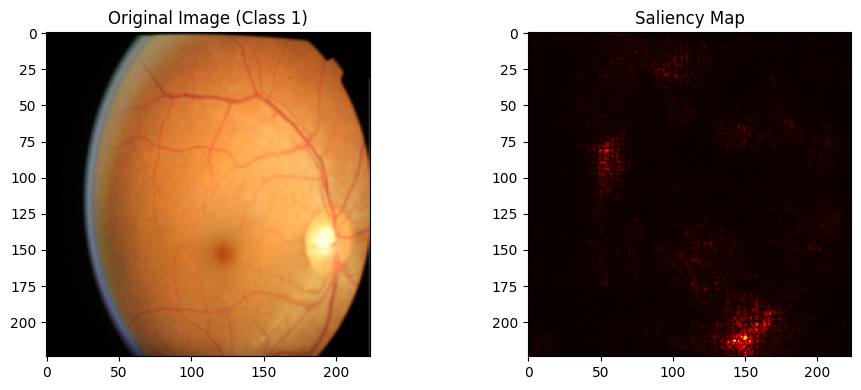

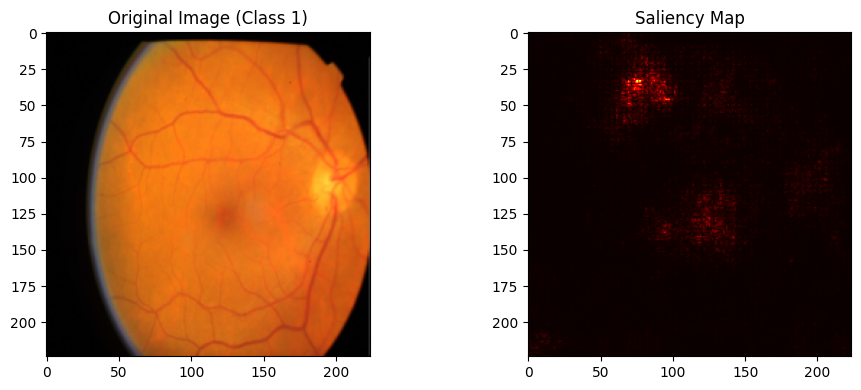

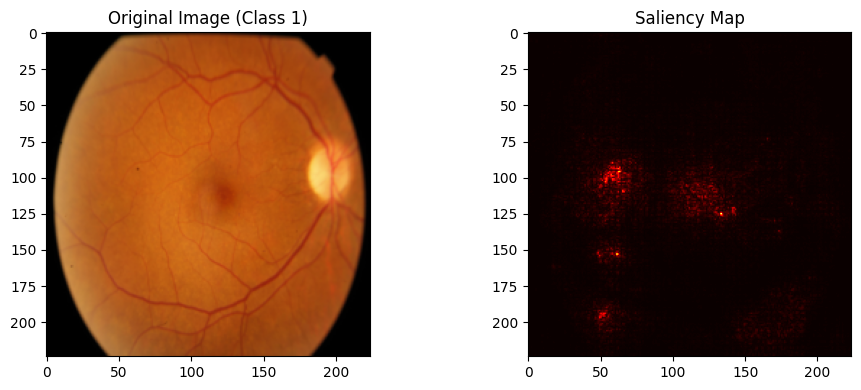

In [21]:
test(model, inadequate_dataloader, saliency=True, device=device)